In [7]:
import os
import sys
import numpy as np
import tensorflow as tf
import input_data
import matplotlib.pyplot as plt
import model_parse as model

In [8]:
# 本例的代码已经不将dropout 优化在内


# you need to change the directories to yours.
train_dir = '../PetImages/train_convert/'
test_dir = '../PetImages/test/'
train_logs_dir = '../logs/train/'
val_logs_dir = '../logs/val'

N_CLASSES = 2
IMG_W = 208     # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
RATIO = 0.2     # take 20% of dataset as validation data
BATCH_SIZE = 64
CAPACITY = 2000
MAX_STEP = 1000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001

In [9]:
tf.reset_default_graph()
param_test = {
    'lr':[0.01,0.001,0.0001],
    'batch_size':[64,128,256]
}
# param_test = {
# #     'lr':[0.01],
#     'batch_size':[128,256]
# }
train, train_label, val, val_label = input_data.get_files(train_dir, RATIO)

There are 11309 cats
There are 11238 dogs


In [10]:
def models_process(param_test):
    models = {
     'lr':{},
     'batch_size':{}
    }

    for key_param,value_param in enumerate(param_test):

        for parm_varm in param_test[value_param]:
            tf.reset_default_graph()
            print('anananan',parm_varm)
            if value_param == 'bacth_size':
             
                train_batch, train_label_batch = input_data.get_batch(train,
                                                              train_label,
                                                              IMG_W,
                                                              IMG_H,
                                                              value_param,
                                                              CAPACITY)
                val_batch, val_label_batch = input_data.get_batch(val,
                                                              val_label,
                                                              IMG_W,
                                                              IMG_H,
                                                              value_param,
                                                              CAPACITY)

                
            #     CNN卷积操作
                logits = model.inference(train_batch, value_param, N_CLASSES)
                
                x = tf.placeholder(tf.float32, shape=[value_param, IMG_W, IMG_H, 3])
                y_ = tf.placeholder(tf.int16, shape=[value_param])
            else:
                             
                train_batch, train_label_batch = input_data.get_batch(train,
                                                              train_label,
                                                              IMG_W,
                                                              IMG_H,
                                                              BATCH_SIZE,
                                                              CAPACITY)
                val_batch, val_label_batch = input_data.get_batch(val,
                                                              val_label,
                                                              IMG_W,
                                                              IMG_H,
                                                              BATCH_SIZE,
                                                              CAPACITY)

                
            #     CNN卷积操作
                logits = model.inference(train_batch, BATCH_SIZE, N_CLASSES)
                
                x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 3])
                y_ = tf.placeholder(tf.int16, shape=[BATCH_SIZE])
            
            
            #scale the float to -2.5 to 2.5
            #train_batch = (1/(2*2.25)) * train_batch + 0.5
        #    损失函数
            loss = model.losses(logits, train_label_batch)
        #     梯度下降
            if value_param == 'lr':
                train_op = model.trainning(loss, parm_varm)
            else:
                train_op = model.trainning(loss)
        #     准确率
            acc = model.evaluation(logits, train_label_batch)



            with tf.Session() as sess:
                saver = tf.train.Saver()
                sess.run(tf.global_variables_initializer())
                coord = tf.train.Coordinator()
                threads = tf.train.start_queue_runners(sess= sess, coord=coord)
        #         tensorboard查看
                summary_op = tf.summary.merge_all()
                train_writer = tf.summary.FileWriter(train_logs_dir, sess.graph)
                val_writer = tf.summary.FileWriter(val_logs_dir, sess.graph)

                steps_val = []
                accuracy_val = []
                loss_tr = []
                steps_tr = []
                accuracy_tr = []
                loss_val = []
        
                try:
                    for step in np.arange(MAX_STEP):
                        if coord.should_stop():
                                break
                        tra_images,tra_labels = sess.run([train_batch, train_label_batch])
                        _, tra_loss, tra_acc = sess.run([train_op, loss, acc],
                                                        feed_dict={x:tra_images, y_:tra_labels})
                        if step % 50 == 0:
                            print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                            summary_str = sess.run(summary_op)
                            train_writer.add_summary(summary_str, step)
                            steps_tr.append(step)
                            accuracy_tr.append(tra_acc)
                            loss_tr.append(tra_loss)

                        if step % 100 == 0 or (step + 1) == MAX_STEP:
                            val_images, val_labels = sess.run([val_batch, val_label_batch])
                            val_loss, val_acc = sess.run([loss, acc],
                                                         feed_dict={x:val_images, y_:val_labels})
                            print('**  Step %d, val loss = %.2f, val accuracy = %.2f%%  **' %(step, val_loss, val_acc*100.0))
                            summary_str = sess.run(summary_op)
                            val_writer.add_summary(summary_str, step)
                            steps_val.append(step)
                            accuracy_val.append(val_acc)
                            loss_val.append(val_loss)

                        if step % 2000 == 0 or (step + 1) == MAX_STEP:
                            checkpoint_path = os.path.join(train_logs_dir, 'model.ckpt')
                            saver.save(sess, checkpoint_path, global_step=step)
                    print(value_param, parm_varm)
                    models[value_param][str(parm_varm)] = {'tr':{'steps_tr':steps_tr,'accuracy_tr':accuracy_tr,'tr_loss':loss_tr},
                                                          'val':{'steps_val':steps_val,'accuracy_val':accuracy_val,'val_loss':loss_val}}
    

                except tf.errors.OutOfRangeError:
                    print('Done training -- epoch limit reached')
                finally:
                    coord.request_stop()
                try:
                    coord.join(threads)
                except:
                    error_type, error_value, trace_back = sys.exc_info()
                    print(error_value)
    return models

In [11]:
# 命令行输入: tensorboard  --logdir=/tmp/mnist 查看结果
# 浏览器输入:127.0.0.1:6006

In [12]:
models = models_process(param_test)

anananan 0.01
conv1:  (64, 208, 208, 16)
norm1:  (64, 104, 104, 16)
conv2:  (64, 104, 104, 16)
pool2:  (64, 104, 104, 16)
local3:  (64, 128)
local4:  (64, 128)
Step 0, train loss = 0.69, train accuracy = 45.31%
**  Step 0, val loss = 96.02, val accuracy = 53.12%  **
Step 50, train loss = 0.70, train accuracy = 45.31%
Step 100, train loss = 0.69, train accuracy = 53.12%
**  Step 100, val loss = 0.69, val accuracy = 57.81%  **
Step 150, train loss = 0.69, train accuracy = 56.25%
Step 200, train loss = 0.69, train accuracy = 59.38%
**  Step 200, val loss = 0.69, val accuracy = 50.00%  **
Step 250, train loss = 0.69, train accuracy = 51.56%
Step 300, train loss = 0.69, train accuracy = 54.69%
**  Step 300, val loss = 0.69, val accuracy = 50.00%  **
Step 350, train loss = 0.70, train accuracy = 40.62%
Step 400, train loss = 0.69, train accuracy = 45.31%
**  Step 400, val loss = 0.69, val accuracy = 56.25%  **
Step 450, train loss = 0.69, train accuracy = 51.56%
Step 500, train loss = 0.69, 

Step 400, train loss = 0.67, train accuracy = 51.56%
**  Step 400, val loss = 0.68, val accuracy = 57.81%  **
Step 450, train loss = 0.60, train accuracy = 68.75%
Step 500, train loss = 0.59, train accuracy = 73.44%
**  Step 500, val loss = 0.57, val accuracy = 75.00%  **
Step 550, train loss = 0.62, train accuracy = 68.75%
Step 600, train loss = 0.60, train accuracy = 62.50%
**  Step 600, val loss = 0.62, val accuracy = 64.06%  **
Step 650, train loss = 0.59, train accuracy = 65.62%
Step 700, train loss = 0.55, train accuracy = 73.44%
**  Step 700, val loss = 0.64, val accuracy = 62.50%  **
Step 750, train loss = 0.65, train accuracy = 60.94%
Step 800, train loss = 0.57, train accuracy = 71.88%
**  Step 800, val loss = 0.54, val accuracy = 71.88%  **
Step 850, train loss = 0.56, train accuracy = 71.88%
Step 900, train loss = 0.54, train accuracy = 68.75%
**  Step 900, val loss = 0.55, val accuracy = 82.81%  **
Step 950, train loss = 0.61, train accuracy = 60.94%
**  Step 999, val loss

In [13]:
models

{'batch_size': {'128': {'tr': {'accuracy_tr': [0.45312,
     0.51562,
     0.60938,
     0.60938,
     0.5625,
     0.5625,
     0.53125,
     0.54688,
     0.51562,
     0.6875,
     0.73438,
     0.6875,
     0.625,
     0.65625,
     0.73438,
     0.60938,
     0.71875,
     0.71875,
     0.6875,
     0.60938],
    'steps_tr': [0,
     50,
     100,
     150,
     200,
     250,
     300,
     350,
     400,
     450,
     500,
     550,
     600,
     650,
     700,
     750,
     800,
     850,
     900,
     950],
    'tr_loss': [0.69352543,
     0.69441104,
     0.67756373,
     0.66484404,
     0.66675746,
     0.67530501,
     0.69121528,
     0.65158677,
     0.66594076,
     0.6007452,
     0.59147698,
     0.62061411,
     0.59681821,
     0.59120685,
     0.55069977,
     0.65291142,
     0.56745064,
     0.56031847,
     0.53710717,
     0.60976481]},
   'val': {'accuracy_val': [0.45312,
     0.65625,
     0.54688,
     0.625,
     0.57812,
     0.75,
     0.64062,
     0

In [14]:
models['batch_size'][str(128)]

{'tr': {'accuracy_tr': [0.45312,
   0.51562,
   0.60938,
   0.60938,
   0.5625,
   0.5625,
   0.53125,
   0.54688,
   0.51562,
   0.6875,
   0.73438,
   0.6875,
   0.625,
   0.65625,
   0.73438,
   0.60938,
   0.71875,
   0.71875,
   0.6875,
   0.60938],
  'steps_tr': [0,
   50,
   100,
   150,
   200,
   250,
   300,
   350,
   400,
   450,
   500,
   550,
   600,
   650,
   700,
   750,
   800,
   850,
   900,
   950],
  'tr_loss': [0.69352543,
   0.69441104,
   0.67756373,
   0.66484404,
   0.66675746,
   0.67530501,
   0.69121528,
   0.65158677,
   0.66594076,
   0.6007452,
   0.59147698,
   0.62061411,
   0.59681821,
   0.59120685,
   0.55069977,
   0.65291142,
   0.56745064,
   0.56031847,
   0.53710717,
   0.60976481]},
 'val': {'accuracy_val': [0.45312,
   0.65625,
   0.54688,
   0.625,
   0.57812,
   0.75,
   0.64062,
   0.625,
   0.71875,
   0.82812,
   0.625],
  'steps_val': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999],
  'val_loss': [0.69510305,
   0.66338712,
   0

0 lr
0.01
{'0.01': {'tr': {'steps_tr': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950], 'accuracy_tr': [0.45312, 0.45312, 0.53125, 0.5625, 0.59375, 0.51562, 0.54688, 0.40625, 0.45312, 0.51562, 0.54688, 0.45312, 0.4375, 0.5625, 0.4375, 0.54688, 0.5, 0.54688, 0.48438, 0.5625], 'tr_loss': [0.6933465, 0.69606751, 0.6923843, 0.68891346, 0.69264793, 0.69281721, 0.69161594, 0.70290887, 0.69320887, 0.69296765, 0.69023299, 0.69344729, 0.69408929, 0.69144619, 0.69477057, 0.69184887, 0.69326615, 0.69108337, 0.69352788, 0.69219106]}, 'val': {'steps_val': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999], 'accuracy_val': [0.53125, 0.57812, 0.5, 0.5, 0.5625, 0.54688, 0.64062, 0.48438, 0.53125, 0.53125, 0.54688], 'val_loss': [96.017296, 0.69121671, 0.69316471, 0.69331324, 0.69308507, 0.6900748, 0.69120276, 0.69359732, 0.69221085, 0.69273078, 0.69201446]}}, '0.001': {'tr': {'steps_tr': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 

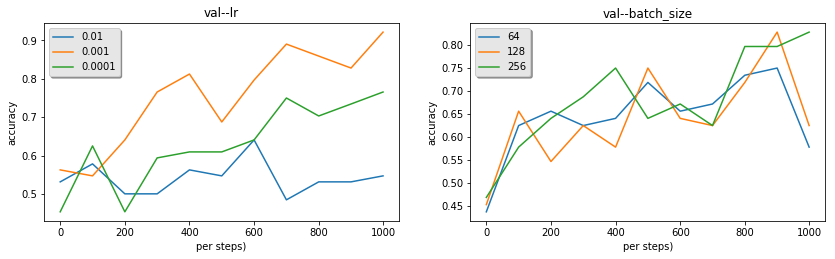

In [15]:
# 绘制不同学习函数 accuracy的曲线
plt.figure(figsize=(14,8))
for param,param_val in enumerate(models):
    print(param,param_val)
    plt.subplot(221+param)
    for inner_key in models[param_val]:
        print(inner_key)
        print(models[param_val])
        plt.plot(models[param_val][inner_key]['val']['steps_val'],models[param_val][inner_key]['val']['accuracy_val'],label=str(inner_key))
        plt.ylabel('accuracy')
        plt.xlabel('per steps')
        plt.title('val--'+param_val)
        legend = plt.legend(loc='best',shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
plt.show()

0 lr
0.01
{'0.01': {'tr': {'steps_tr': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950], 'accuracy_tr': [0.45312, 0.45312, 0.53125, 0.5625, 0.59375, 0.51562, 0.54688, 0.40625, 0.45312, 0.51562, 0.54688, 0.45312, 0.4375, 0.5625, 0.4375, 0.54688, 0.5, 0.54688, 0.48438, 0.5625], 'tr_loss': [0.6933465, 0.69606751, 0.6923843, 0.68891346, 0.69264793, 0.69281721, 0.69161594, 0.70290887, 0.69320887, 0.69296765, 0.69023299, 0.69344729, 0.69408929, 0.69144619, 0.69477057, 0.69184887, 0.69326615, 0.69108337, 0.69352788, 0.69219106]}, 'val': {'steps_val': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999], 'accuracy_val': [0.53125, 0.57812, 0.5, 0.5, 0.5625, 0.54688, 0.64062, 0.48438, 0.53125, 0.53125, 0.54688], 'val_loss': [96.017296, 0.69121671, 0.69316471, 0.69331324, 0.69308507, 0.6900748, 0.69120276, 0.69359732, 0.69221085, 0.69273078, 0.69201446]}}, '0.001': {'tr': {'steps_tr': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 

256
{'64': {'tr': {'steps_tr': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950], 'accuracy_tr': [0.51562, 0.54688, 0.4375, 0.57812, 0.54688, 0.48438, 0.60938, 0.6875, 0.64062, 0.75, 0.64062, 0.67188, 0.64062, 0.65625, 0.6875, 0.76562, 0.64062, 0.65625, 0.64062, 0.75], 'tr_loss': [0.69304639, 0.69168341, 0.71273345, 0.67155337, 0.67412478, 0.69091284, 0.66579318, 0.60025799, 0.67220575, 0.5752703, 0.62836218, 0.59790003, 0.63559067, 0.58164167, 0.56606466, 0.49719006, 0.64132702, 0.62056839, 0.62287408, 0.5367409]}, 'val': {'steps_val': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999], 'accuracy_val': [0.4375, 0.625, 0.65625, 0.625, 0.64062, 0.71875, 0.65625, 0.67188, 0.73438, 0.75, 0.57812], 'val_loss': [0.69517624, 0.64511645, 0.6398896, 0.63400996, 0.59684348, 0.61289901, 0.5917809, 0.61736798, 0.60527426, 0.53510016, 0.60898066]}}, '128': {'tr': {'steps_tr': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,

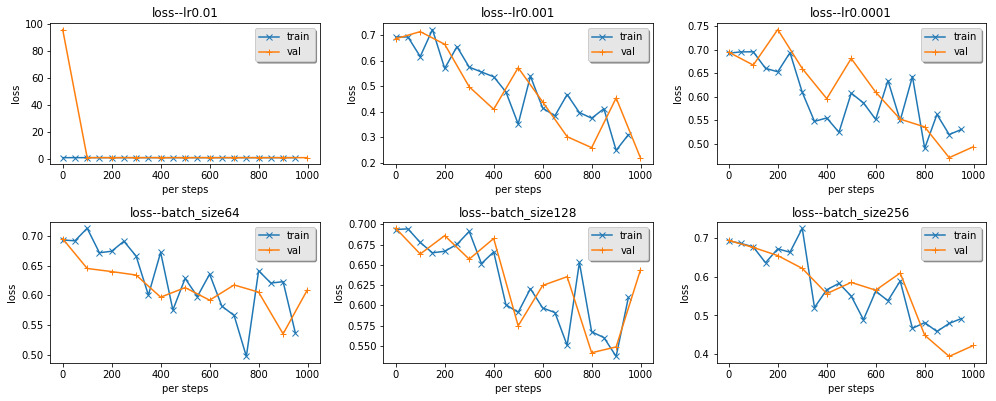

In [19]:
plt.figure(figsize=(14,8))
i = 0
for param,param_val in enumerate(models):
    print(param,param_val)
    
    for inner_key in models[param_val]:       
        plt.subplot(331+i)
        plt.tight_layout()
        print(inner_key)
        print(models[param_val])
        plt.plot(models[param_val][inner_key]['tr']['steps_tr'],models[param_val][inner_key]['tr']['tr_loss'],"x-",label='train')
                 
        plt.plot(models[param_val][inner_key]['val']['steps_val'],models[param_val][inner_key]['val']['val_loss'],"+-",label='val')
      
        plt.ylabel('loss')
        plt.xlabel('per steps')
        plt.title('loss--'+param_val+str(inner_key))
        legend = plt.legend(loc='best',shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        i = i + 1
plt.show()